# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import random
import plotly.io as pio

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_comunidades = "../../../reports/reports_nohubs/analisis_comunidades/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts()/2)
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

G = nx.read_gml(graph_data+"nohub_disease_layer.gml", destringizer=int)
enfermedades = graph_node_data[(graph_node_data.node_type == "disease")|(graph_node_data.node_type == "bert_group")]

,Número de nodos
bert_group,1040
complex,421
disease,15039
gene_protein,17322
pathway,2017
total,35839


,Número de enlaces
disease_disease,16433.0
form_complex,1885.0
gda,84014.0
pathway_protein,42643.0
ppi,110051.0
total,255026.0


# Cartographic Role - Infomap

## Within-module degree:

Para cada nodo $i$, perteneciente a una comunidad $s_{i}$, calculo el "grado interno" $z_i$:

$ z_{i} = \frac{k_{i} - \bar{k}_{s_i}}{\sigma_{k_{si}}}$

Donde $k_i$ es el número de enlaces de $i$ a otros nodos de su comunidad, $\bar{k}_{s_i}$ es el promedio de $k$ sobre todos los nodos de la comunidad y $\sigma_{k_{si}}$ el desvío estandar de $k$ en $s_i$.


In [5]:
comunidades_infomap = enfermedades.comunidades_infomap.dropna().astype("int").sort_values().unique()
comunidades_louvain = enfermedades.comunidades_louvain.dropna().astype("int").sort_values().unique()

In [5]:
grafos_comunidades = {}

for comunidad in comunidades_infomap:
    nodos = graph_node_data.loc[graph_node_data.comunidades_infomap == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [6]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [7]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_7657/3316443242.py:8: RuntimeWarning: invalid value encountered in double_scalars
  node_z_score = round((k_i - k_si)/sigma_k,2)


Dejo los nan afuera del análisis porque salen de comunidades con sigma=0. Son comunidades chiquitas de 2 nodos que no tiene mucho sentido analizar por ahí.

## Participation coefficient

$P_i = 1 - \sum_{s=1}^{N_M} (\frac{k_{i_s}}{k_i})^2$

Donde $k_{i_s}$ es el número de enlaces del nodo i a nodos del módulo s (sumo sobre todos los módulos) y ${k_i}$ es el grado **total** del nodo i.

In [8]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_infomap"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

## Roles cartográficos

Para cada nodo (solo los BERTs) calculo la región Rn (n = [1,7]) según sus valores de z y p, como dice el paper. Al final de todo hago un gráfico con las regiones (quizás mostrando algunos nodos)

In [11]:
def cartographic_role(z,p):
    #nodos non-hub
    if z < 2.5:
        if p <= 0.05:
            role = 1
        elif p <= 0.62:
            role = 2
        elif p <= 0.8:
            role = 3
        else:
            role = 4

    #nodos hub
    else:
        if p <= 0.3:
            role = 5
        elif p<= 0.75:
            role = 6
        else:
            role = 7
            
    return role

In [10]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [14]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
infomap_results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [15]:
role_names = {1:"Ultra Periférico", 2:"Periférico",3:"Conector no-hub",4:"Kinless no-hub",5:"Hub provincial",6:"Hub conector",7:"Hub Kinless"}
infomap_results_df["role_name"] = infomap_results_df.role.apply(lambda x: role_names[x])
color_discrete_map = {name:px.colors.qualitative.G10[i] for i,name in role_names.items()}
color_discrete_map["other"] = "#808080"

In [16]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
non_berts = graph_node_data.loc[graph_node_data.node_type == "disease", "node_index"].values
infomap_bert_roles = infomap_results_df.loc[berts].sort_values(by="role").reset_index()
infomap_non_bert_roles = infomap_results_df.loc[infomap_results_df.index.intersection(non_berts)].sort_values(by="role").reset_index()

Text(0.5, 1.0, 'Rol cartográfico - Infomap')

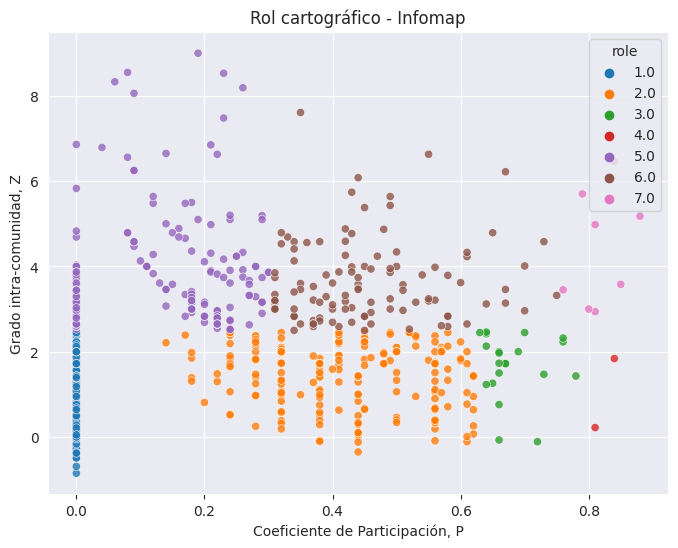

In [17]:
fig,ax = plt.subplots(figsize=(8,6))

joint = sns.scatterplot(data=infomap_bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)

ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")
ax.set_title("Rol cartográfico - Infomap")
# fig.savefig(reports_comunidades+"scatter_rol_cartografico_infomap.png",dpi=200)

In [19]:
range_infomap = ([-0.05,1],[-2.5,10])

In [20]:
fig = px.scatter(infomap_bert_roles.rename(columns={"role_name":"Rol Cartográfico"}), x="participation_coefficient", y="intra_degree",range_x=range_infomap[0],range_y=range_infomap[1], width=800, height=500, color="Rol Cartográfico", marginal_x="histogram",marginal_y="histogram", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Coeficiente de Participación - P", yaxis_title="Grado intra-módulo - Z")

# x1=0.8358,x2=0.8408
x1_, x2_ = 0.89, 0.9
# y1=0.7326, y2=0.7426
y1_, y2_ = 0.79, 0.81
fig.layout.xaxis.domain = (0.0, x1_)
fig.layout.xaxis2.domain = (x2_, 1.0)
fig.layout.xaxis3.domain = (0.0, x1_)
fig.layout.xaxis4.domain = (x2_, 1.0)
fig.layout.yaxis.domain = (0.0, y1_)
fig.layout.yaxis2.domain = (0.0, y1_)
fig.layout.yaxis3.domain = (y2_, 1.0)
fig.layout.yaxis4.domain = (y2_, 1.0)

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_infomap_interactivo.html")

In [21]:
def pie_plot(df,other_percent):
    tot = len(df)
    vals = df.role_name.value_counts()
    percent = vals.apply(lambda x: round((x*100)/tot))
    percent = percent.drop(index=percent[percent < other_percent].index.values)
    percent["Otros"] = 100 - percent.sum()
    color_discrete_map = {name:px.colors.qualitative.G10[i] for i,name in role_names.items()}
    color_discrete_map["Otros"] = "#808080"
    colors = [color_discrete_map[label] for label in percent.index]
    fig, ax = plt.subplots()
    ax.pie(percent.values, labels=percent.index, autopct='%1.1f%%',shadow=True, startangle=90)
    ax.axis('equal')
    plt.show()

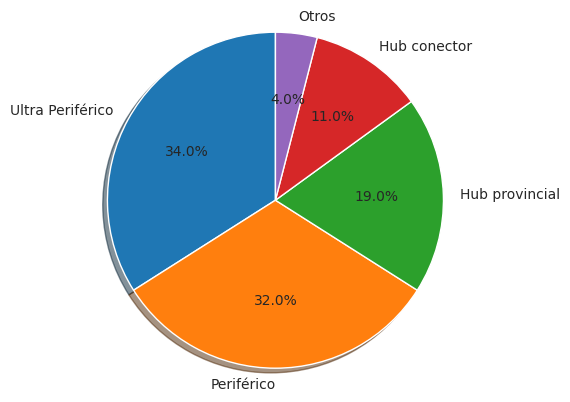

In [22]:
pie_plot(infomap_bert_roles,10)

Analizar ejemplos de Berts conectores

In [37]:
infomap_results_df.loc[18729]

role                                  6.0
intra_degree                         3.63
participation_coefficient            0.59
role_name                    Hub conector
Name: 18729, dtype: object

In [51]:
ejemplo = 18729
graph_node_data[graph_node_data.node_index == ejemplo]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
11118,18729,C0005686,Urinary Bladder Diseases,disease,disgenet,29.0,8.0,5.0,0.0,18.0


In [52]:
comunidad = graph_node_data.loc[graph_node_data.node_index == ejemplo, "comunidades_infomap"].values[0]
graph_node_data[graph_node_data.comunidades_infomap == comunidad]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
1708,19402,C0016978,gallbladder neoplasm,disease,disgenet,29.0,3.0,11.0,0.0,4.0
11118,18729,C0005686,Urinary Bladder Diseases,disease,disgenet,29.0,8.0,5.0,0.0,18.0
12739,25944,C0878773,Overactive Bladder,disease,disgenet,29.0,8.0,4.0,0.0,1.0
20661,18727,C0005683,Urinary Bladder Calculi (disorder),disease,disgenet,29.0,8.0,1.0,0.0,1.0
21552,22420,C0238137,Gallbladder adenoma,disease,disgenet,29.0,3.0,0.0,0.0,3.0
26942,18916,C0008350,Cholelithiasis,disease,disgenet,29.0,8.0,2.0,0.0,2.0
29441,25992,C0947622,Cholecystolithiasis,disease,disgenet,29.0,8.0,1.0,0.0,1.0
29466,10475,5281_12365_12366,gallbladder disease,bert_group,primekg,29.0,8.0,0.0,0.0,10.0
29467,19401,C0016977,Gall Bladder Diseases,disease,disgenet,29.0,8.0,0.0,0.0,1.0
29468,29333,C1969115,GALLBLADDER DISEASE 4,disease,disgenet,29.0,8.0,1.0,0.0,2.0


In [54]:
graph_node_data.set_index("node_index",drop=True).loc[list(G.neighbors(ejemplo))]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
18732,C0005695,Bladder Neoplasm,disease,disgenet,28.0,3.0,140.0,0.0,5.0
25944,C0878773,Overactive Bladder,disease,disgenet,29.0,8.0,4.0,0.0,1.0
18727,C0005683,Urinary Bladder Calculi (disorder),disease,disgenet,29.0,8.0,1.0,0.0,1.0
19056,C0010692,Cystitis,disease,disgenet,32.0,8.0,4.0,0.0,9.0
18916,C0008350,Cholelithiasis,disease,disgenet,29.0,8.0,2.0,0.0,2.0
29333,C1969115,GALLBLADDER DISEASE 4,disease,disgenet,29.0,8.0,1.0,0.0,2.0
18731,C0005694,Bladder neck obstruction,disease,disgenet,29.0,8.0,1.0,0.0,1.0
16859,8653_12573_13356_10755_14422_6007_13682_13683_...,vesicoureteral reflux,bert_group,primekg,33.0,9.0,0.0,0.0,7.0
26620,C1335051,Non-Neoplastic Urinary System Disorder,disease,disgenet,30.0,8.0,0.0,0.0,8.0


In [27]:
fig = px.scatter(infomap_non_bert_roles, x="participation_coefficient", y="intra_degree", width=800, height=500, range_x=range_infomap[0],range_y=range_infomap[1],color="role_name",text="index",marginal_x="histogram",marginal_y="histogram", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Coeficiente de Participación - P", yaxis_title="Grado intra-módulo - Z")

# x1=0.8358,x2=0.8408
x1_, x2_ = 0.89, 0.9
# y1=0.7326, y2=0.7426
y1_, y2_ = 0.79, 0.81
fig.layout.xaxis.domain = (0.0, x1_)
fig.layout.xaxis2.domain = (x2_, 1.0)
fig.layout.xaxis3.domain = (0.0, x1_)
fig.layout.xaxis4.domain = (x2_, 1.0)
fig.layout.yaxis.domain = (0.0, y1_)
fig.layout.yaxis2.domain = (0.0, y1_)
fig.layout.yaxis3.domain = (y2_, 1.0)
fig.layout.yaxis4.domain = (y2_, 1.0)

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_no_berts_infomap_interactivo.html")

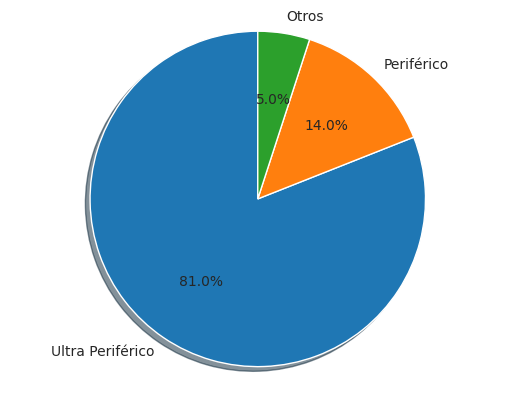

In [80]:
pie_plot(non_bert_roles,10)

In [26]:
graph_node_data[graph_node_data.node_index == 24773]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
7836,24773,C0520572,Enzymopathy,disease,disgenet,349.0,32.0,11.0,0.0,66.0


Los nodos BERT tienen un rol conector dentro de sus comunidades, pero además tienen participación no nula, entonces conectan módulos entre sí. 

Se observan pocos valores negativos: los bert tienden a tener grado mayor a la media del módulo (recordar que el eje y está estandarizado)

### graficos de barra

In [27]:
fig = px.histogram(bert_roles, x="role", width=800, height=600, color="role_name", title="Rol cartográfico nodos BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Rol Cartográfico", yaxis_title="Count")
fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_infomap_barras_interactivo.html")

In [28]:
fig = px.histogram(non_bert_roles, x="role", width=800, height=600, color="role_name", title="Rol cartográfico nodos no-BERT - Infomap", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Rol Cartográfico", yaxis_title="Count")
fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_no_berts_infomap_barras_interactivo.html")

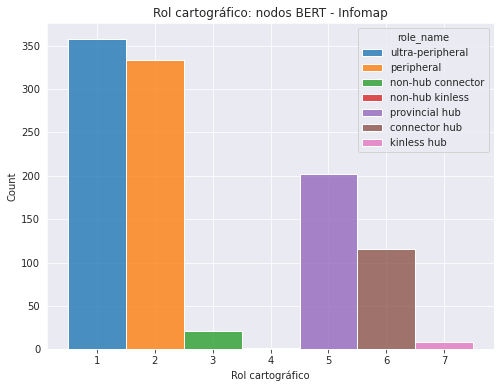

In [71]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos BERT - Infomap")
sns.histplot(data=bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap.png",dpi=200)

Para este grafico sacar los berts 

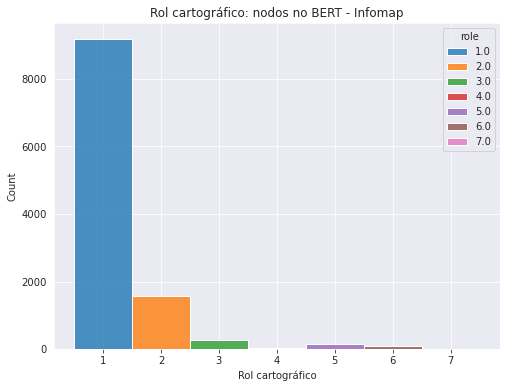

In [72]:
fig,ax = plt.subplots(figsize=(8,6))
sns.histplot(data=non_bert_roles, x="role", hue="role", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_title("Rol cartográfico: nodos no BERT - Infomap")
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_infomap_no_berts.png",dpi=200)

# Cartographic Role - Louvain

In [6]:
grafos_comunidades = {}

for comunidad in comunidades_louvain:
    nodos = graph_node_data.loc[graph_node_data.comunidades_louvain == comunidad, "node_index"].values
    edges = graph_edge_data.loc[graph_edge_data.y_index.isin(nodos) & graph_edge_data.x_index.isin(nodos), ["y_index","x_index"]].reset_index(drop=True)
    H = nx.from_pandas_edgelist(edges,source="x_index",target="y_index")
    grafos_comunidades[comunidad] = H

In [7]:
k_medio = {}
for comunidad,grafo in grafos_comunidades.items():
    H = grafo
    num_nodes = H.number_of_nodes()
    k_values = np.array([k for (node,k) in list(H.degree())])
    avg_k = np.round(np.mean(k_values),2)
    std_k = np.round(np.std(k_values),2)
    k_medio[comunidad] = {"avg_k":avg_k, "std_k":std_k}

In [8]:
z_score = {}

for comunidad, H in grafos_comunidades.items():
    degrees = dict(H.degree())
    for node, k_i in degrees.items():
        k_si = k_medio[comunidad]["avg_k"]
        sigma_k = k_medio[comunidad]["std_k"]
        node_z_score = round((k_i - k_si)/sigma_k,2)
        z_score[node] = node_z_score

/tmp/ipykernel_25477/3316443242.py:8: RuntimeWarning: invalid value encountered in double_scalars
  node_z_score = round((k_i - k_si)/sigma_k,2)


In [9]:
participation_coefficient = {}
total_degrees = dict(G.degree())

for node in list(G.nodes()):

    node_total_degree = total_degrees[node]
    vecinos = list(G.neighbors(node))
    k_is_dict = enfermedades.set_index("node_index").loc[vecinos,"comunidades_louvain"].astype("int").value_counts().to_dict()

    valores_s = []
    for comunidad, grado_kis in k_is_dict.items():
        sum_term = (grado_kis/node_total_degree)**2
        valores_s.append(sum_term)

    sumatoria = sum(valores_s)
    P_i = round(1 - sumatoria,2)
    participation_coefficient[node] = P_i

In [29]:
cartographic_roles = {}
for node in list(G.nodes()):
    z = z_score[node]
    p = participation_coefficient[node]
    cartographic_roles[node] = cartographic_role(z,p)

In [30]:
cartography_series = pd.Series(cartographic_roles, name="role")
z_score_series = pd.Series(z_score, name="intra_degree")
participation_series = pd.Series(participation_coefficient, name="participation_coefficient")
louvain_results_df = pd.DataFrame([cartography_series,z_score_series,participation_series]).T

In [34]:
role_names = {1:"Ultra Periférico", 2:"Periférico",3:"Conector no-hub",4:"Kinless no-hub",5:"Hub provincial",6:"Hub conector",7:"Hub Kinless"}
louvain_results_df["Rol Cartográfico"] = louvain_results_df.role.apply(lambda x: role_names[x])
color_discrete_map = {name:px.colors.qualitative.G10[i] for i,name in role_names.items()}

In [36]:
berts = graph_node_data.loc[graph_node_data.node_type == "bert_group", "node_index"].values
non_berts = graph_node_data.loc[graph_node_data.node_type == "disease", "node_index"].values
louvain_bert_roles = louvain_results_df.loc[berts].sort_values(by="role").reset_index()
louvain_non_bert_roles = louvain_results_df.loc[louvain_results_df.index.intersection(non_berts)].sort_values(by="role").reset_index()

In [21]:
# range_louvain = ([-0.05,1],[-2.5,16])
range_louvain = ([-0.05,1],[-2.5,16])

In [37]:
fig = px.scatter(louvain_bert_roles, x="participation_coefficient", y="intra_degree",text="index",range_x=range_louvain[0],range_y=range_louvain[1], width=800, height=500, color="Rol Cartográfico", marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico grupos BERT - Louvain", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Coeficiente de Participación - P", yaxis_title="Grado intra-módulo - Z")
# x1=0.8358,x2=0.8408
x1_, x2_ = 0.89, 0.9
# y1=0.7326, y2=0.7426
y1_, y2_ = 0.79, 0.81
fig.layout.xaxis.domain = (0.0, x1_)
fig.layout.xaxis2.domain = (x2_, 1.0)
fig.layout.xaxis3.domain = (0.0, x1_)
fig.layout.xaxis4.domain = (x2_, 1.0)
fig.layout.yaxis.domain = (0.0, y1_)
fig.layout.yaxis2.domain = (0.0, y1_)
fig.layout.yaxis3.domain = (y2_, 1.0)
fig.layout.yaxis4.domain = (y2_, 1.0)

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_berts_louvain_interactivo.html")

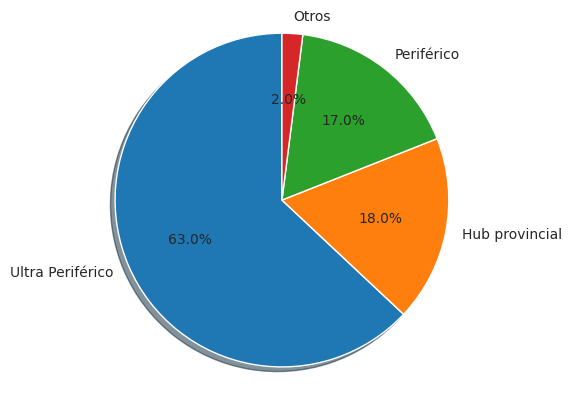

In [65]:
pie_plot(bert_roles,10)

In [40]:
fig = px.scatter(louvain_non_bert_roles, x="participation_coefficient", y="intra_degree", width=800, height=500,range_x=range_louvain[0],range_y=range_louvain[1],color="Rol Cartográfico",text="index",marginal_x="histogram",marginal_y="histogram", title="Rol cartográfico nodos no-BERT - Louvain", color_discrete_map=color_discrete_map)
fig.update_layout(xaxis_title="Coeficiente de Participación - P", yaxis_title="Grado intra-módulo - Z")

# x1=0.8358,x2=0.8408
x1_, x2_ = 0.89, 0.9
# y1=0.7326, y2=0.7426
y1_, y2_ = 0.79, 0.81
fig.layout.xaxis.domain = (0.0, x1_)
fig.layout.xaxis2.domain = (x2_, 1.0)
fig.layout.xaxis3.domain = (0.0, x1_)
fig.layout.xaxis4.domain = (x2_, 1.0)
fig.layout.yaxis.domain = (0.0, y1_)
fig.layout.yaxis2.domain = (0.0, y1_)
fig.layout.yaxis3.domain = (y2_, 1.0)
fig.layout.yaxis4.domain = (y2_, 1.0)

fig.show()
# fig.write_html(reports_comunidades + "rol_cartografico_no_berts_louvain_interactivo.html")

Text(0.5, 1.0, 'Rol cartográfico - Louvain')

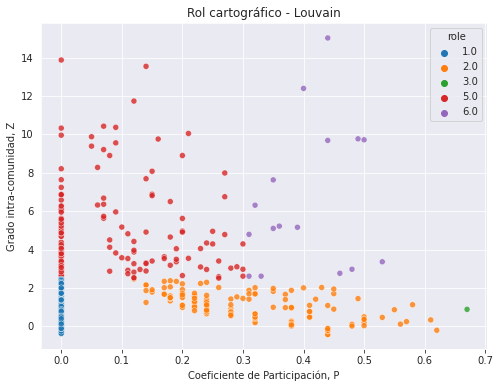

In [49]:
fig,ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=bert_roles, x="participation_coefficient", y="intra_degree", hue="role", ax=ax, palette="tab10", alpha=0.8)
ax.set_xlabel("Coeficiente de Participación, P")
ax.set_ylabel("Grado intra-comunidad, Z")

ax.set_title("Rol cartográfico - Louvain")
# fig.savefig(reports_comunidades+"scatter_rol_cartografico_louvain.png",dpi=200)

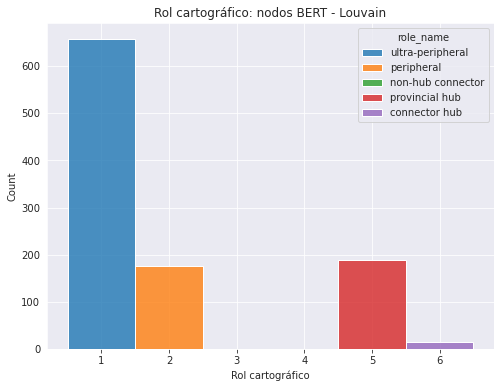

In [84]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos BERT - Louvain")
sns.histplot(data=bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain.png",dpi=200)

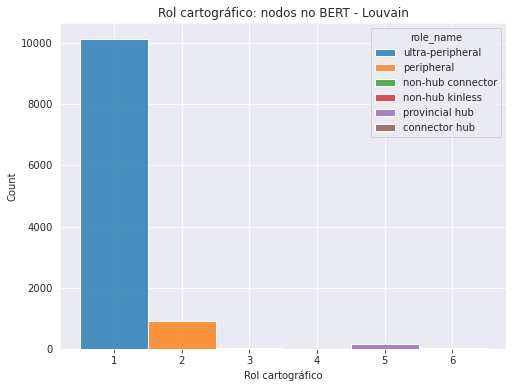

In [85]:
fig,ax = plt.subplots(figsize=(8,6))
ax.set_title("Rol cartográfico: nodos no BERT - Louvain")
sns.histplot(data=non_bert_roles, x="role", hue="role_name", palette="tab10", alpha=0.8, ax=ax, discrete=True)
ax.set_xlabel("Rol cartográfico")
# fig.savefig(reports_comunidades+"barras_rol_cartografico_louvain_nonbert.png",dpi=200)

### Subfigs graficos de torta

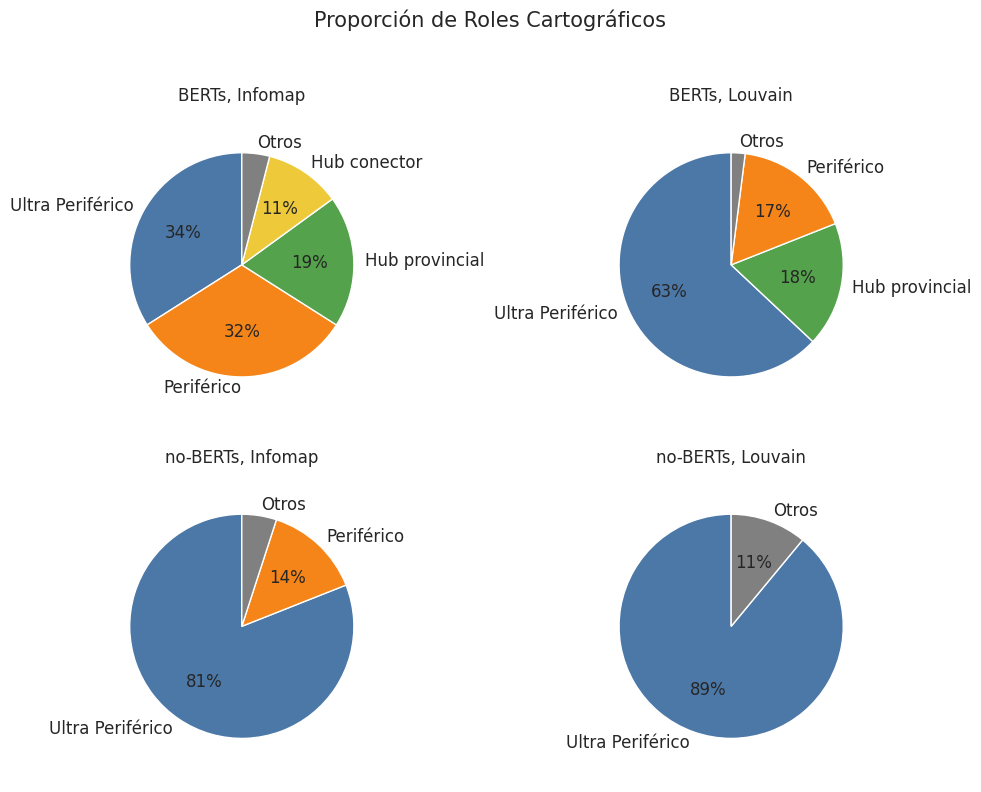

In [146]:
import matplotlib.pyplot as plt
import plotly.express as px  # For color maps

def pie_plot_ax(ax, df, other_percent):
    tot = len(df)
    vals = df.role_name.value_counts()
    percent = vals.apply(lambda x: round((x*100)/tot))
    percent = percent.drop(index=percent[percent < other_percent].index.values)
    percent["Otros"] = 100 - percent.sum()
    
    # Ensure role_names is defined and maps roles to colors
    role_names = {1:"Ultra Periférico", 2:"Periférico",3:"Conector no-hub",4:"Kinless no-hub",5:"Hub provincial",6:"Hub conector",7:"Hub Kinless"}
    color_discrete_map = {name: px.colors.qualitative.T10[i-1] for i, name in role_names.items()}
    color_discrete_map["Otros"] = "#808080"
    
    colors = [color_discrete_map[label] for label in percent.index]
    ax.pie(percent.values, labels=percent.index, colors=colors, autopct=lambda p: f'{p:.0f}%' if p > 6 else '',
           shadow=False, startangle=90, textprops={'size': 'large'}, radius=0.9)

reports_figs = "../../../reports/figs_p_tesis/"

cases = {
    "BERTs, Infomap": infomap_bert_roles,
    "BERTs, Louvain": louvain_bert_roles,
    "no-BERTs, Infomap": infomap_non_bert_roles,
    "no-BERTs, Louvain": louvain_non_bert_roles
}

plt.figure(figsize=(10, 8))  # Adjust size to fit the content
plt.suptitle("Proporción de Roles Cartográficos", fontsize=15, y=1, x=0.5)

for i, (title, x) in enumerate(cases.items()):
    ax = plt.subplot(2, 2, i + 1)
    ax.set_title(title)
    pie_plot_ax(ax, x, 10)

plt.tight_layout(pad=2.0)  # Adjust padding if needed
plt.savefig(reports_figs + "pieplots_roles.png", format="png", dpi=300, bbox_inches='tight')
plt.show()


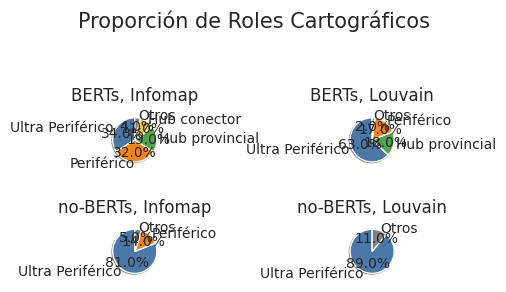

In [134]:
def pie_plot_ax(ax,df,other_percent):
    tot = len(df)
    vals = df.role_name.value_counts()
    percent = vals.apply(lambda x: round((x*100)/tot))
    percent = percent.drop(index=percent[percent < other_percent].index.values)
    percent["Otros"] = 100 - percent.sum()
    color_discrete_map = {name:px.colors.qualitative.T10[i-1] for i,name in role_names.items()}
    color_discrete_map["Otros"] = "#808080"
    colors = [color_discrete_map[label] for label in percent.index]
    ax.pie(percent.values, labels=percent.index,colors=colors, autopct='%1.1f%%',shadow=True, startangle=90,textprops={'size': 'medium'}, radius=0.9)

reports_figs = "../../../reports/figs_p_tesis/"

cases = {"BERTs, Infomap":infomap_bert_roles, "BERTs, Louvain":louvain_bert_roles, "no-BERTs, Infomap":infomap_non_bert_roles, "no-BERTs, Louvain":louvain_non_bert_roles}

plt.figure(figsize=(5,3))
plt.suptitle("Proporción de Roles Cartográficos", fontsize=15,y=1,x=0.5)

for i, data in enumerate(cases.items()):
    ax = plt.subplot(2, 2, i + 1)
    title = data[0]
    x = data[1]
    ax.set_title(title)
    pie_plot_ax(ax,x,10)

plt.tight_layout(pad=2.0)
plt.savefig(reports_figs+"pieplots_roles.png",format="png", dpi=300,bbox_inches='tight')